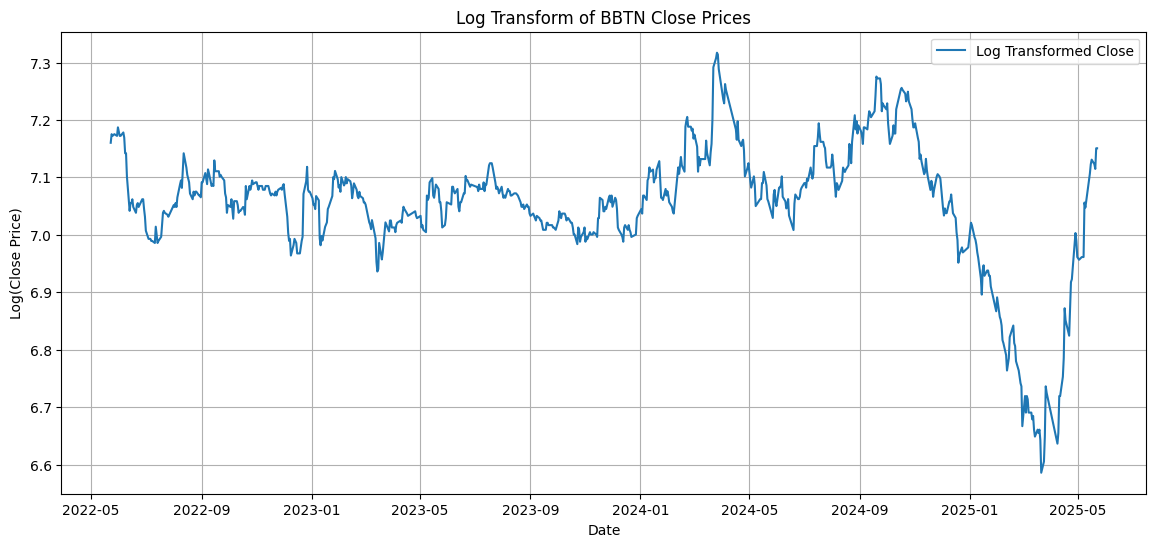

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Baca file Excel
file_path = 'DATA BBTN13.xlsx'
df = pd.read_excel(file_path, sheet_name='DATA')

# Konversi kolom Date ke datetime
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Set kolom Date sebagai index
df.set_index('Date', inplace=True)

# Tambahkan kolom log transformasi dari harga penutupan
df['Log_Close'] = np.log(df['Close'])

# Plot Log Transform dari Close
plt.figure(figsize=(14, 6))
plt.plot(df['Log_Close'], label='Log Transformed Close')
plt.title('Log Transform of BBTN Close Prices')
plt.xlabel('Date')
plt.ylabel('Log(Close Price)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro

warnings.filterwarnings("ignore")

In [7]:
df = pd.read_excel("/content/DATA BBTN13.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
ts = df['Close']

In [8]:
adf_result = adfuller(ts)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -2.7105395489129855
p-value: 0.07223215650687992


In [9]:
if adf_result[1] > 0.05:
    ts_diff = ts.diff().dropna()
    print("Data sudah didifferencing.")
else:
    ts_diff = ts
    print("Data sudah stasioner.")

Data sudah didifferencing.


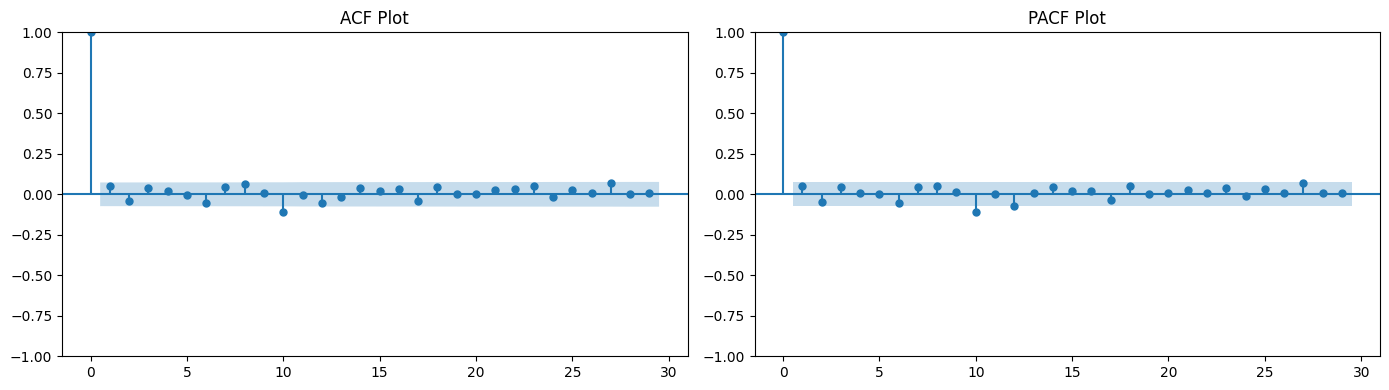

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts_diff, ax=axes[0])
plot_pacf(ts_diff, ax=axes[1])
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()

In [11]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
aic_values = []
orders = []

for order in pdq:
    try:
        model = ARIMA(ts, order=order)
        result = model.fit()
        aic_values.append(result.aic)
        orders.append(order)
    except:
        continue

aic_df = pd.DataFrame({'Order': orders, 'AIC': aic_values})
best_order = aic_df.sort_values('AIC').iloc[0]
print("Best ARIMA Order:", best_order['Order'], "with AIC:", best_order['AIC'])

Best ARIMA Order: (1, 1, 1) with AIC: 6546.972408909083


In [15]:
model = ARIMA(ts, order=best_order['Order'])
results = model.fit()

summary_str = str(results.summary())
summary_str = summary_str.replace("SARIMAX Results", "ARIMA Results")
print(summary_str)

                               ARIMA Results                                
Dep. Variable:                  Close   No. Observations:                  720
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3270.486
Date:                Sat, 07 Jun 2025   AIC                           6546.972
Time:                        11:30:16   BIC                           6560.706
Sample:                             0   HQIC                          6552.275
                                - 720                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8292      0.103     -8.045      0.000      -1.031      -0.627
ma.L1          0.8823      0.084     10.452      0.000       0.717       1.048
sigma2       522.8847     17.689     29.560      0.000

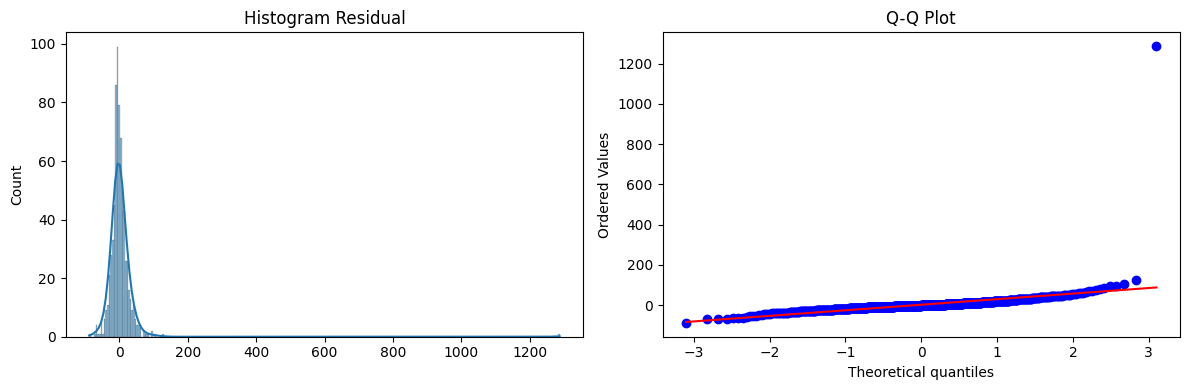

Ljung-Box p-value: 0.9961187197439956
Shapiro-Wilk p-value: 3.3201300303358902e-46


In [18]:
residuals = results.resid

# Plot residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(residuals, kde=True, ax=ax[0])
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax[1])
ax[0].set_title("Histogram Residual")
ax[1].set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Uji Ljung-Box
ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box p-value:", ljung_box["lb_pvalue"].values[0])

# Uji Normalitas (Shapiro-Wilk)
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

In [19]:
# Bagi data menjadi train dan test (80-20)
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

model = ARIMA(train, order=best_order['Order'])
fit = model.fit()
forecast = fit.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)

MAE: 255.7774939948044
MSE: 92849.90898279613
MAPE: nan


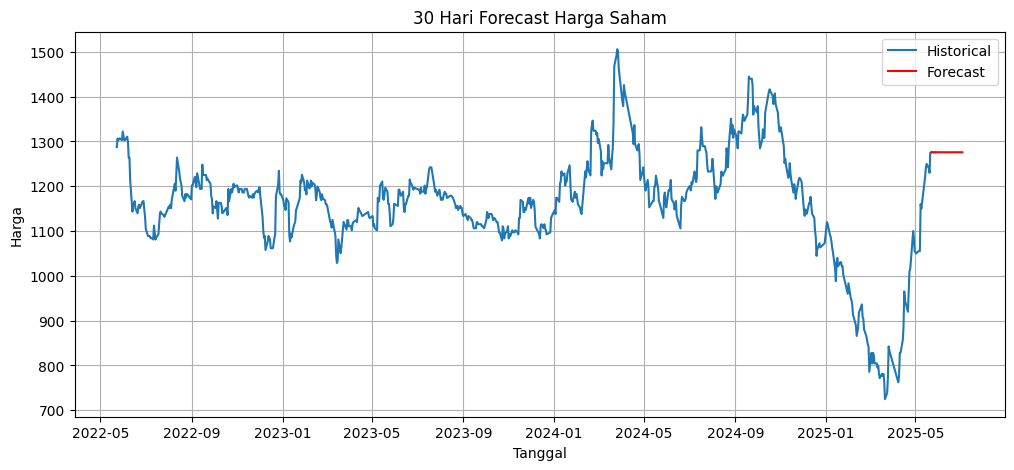

In [20]:
n_forecast = 30  # hari ke depan
future_forecast = results.forecast(steps=n_forecast)

plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical')
plt.plot(pd.date_range(ts.index[-1], periods=n_forecast + 1, freq='B')[1:], future_forecast, label='Forecast', color='red')
plt.legend()
plt.title("30 Hari Forecast Harga Saham")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.grid()
plt.show()

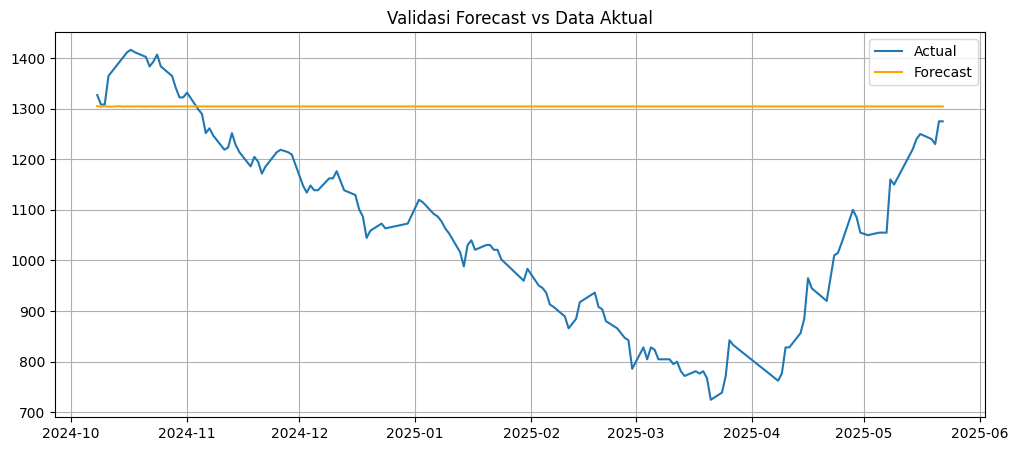

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.legend()
plt.title("Validasi Forecast vs Data Aktual")
plt.grid()
plt.show()